# COMP 532 - Deep Q-Network Atari Gym Implementation

This notebook implements a DQN - an approximate q-learning algorithm with experience replay and target networks based on the original DQN Atari paper. 

The algorithm is used on the gym enviroment on the MsPacman Atari game




In [ ]:
#Make necessary imports
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]
%pip install -U ale-py

import gym
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import trange # for visual training updates :)
from IPython.display import clear_output
from pandas import DataFrame
%matplotlib inline

from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

# from gym.spaces.box import Box
from gym.core import Wrapper

#Import TensorFlow and Keras
%tensorflow_version 1.x # issues with newer version of tf and gym
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, InputLayer

### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [ ]:


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (84, 84)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        """what happens to each observation"""
        
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
        
        # resize image
        img = cv2.resize(img, self.img_size)
        
        img = img.mean(-1,keepdims=True)
        
        img = img.astype('float32') / 255.
              
        return img


### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images.


In [ ]:

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        # self.dim_order = dim_order
        height, width, n_channels = env.observation_space.shape
        """Multiply channels dimension by number of frames"""
        obs_shape = [height, width, n_channels * n_frames] 
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        offset = self.env.observation_space.shape[-1]
        axis = -1
        cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)


In [ ]:
def make_env():
    env = gym.make("ALE/MsPacman-v5")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4)
    return env

In [ ]:
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

for _ in range(17): # MsPacman-v0 waits for 90 actions before the episode begins 
  env.step(0)

In [ ]:
print(n_actions)
print(state_dim)

9
(84, 84, 4)


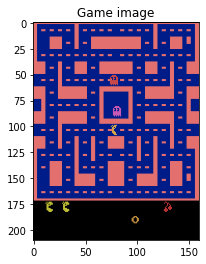

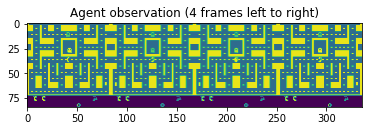

In [ ]:
# review Atari image, and actual observation of the Agent after processing
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

### Building a network

We now need to build a neural network that can map images to state q-values. We use strided convolutions with a small number of features to save time and memory.

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            self.network = keras.models.Sequential()
            # state_shape for the input shape
            self.network.add(Conv2D(32, (8, 8), strides=4, activation='relu',use_bias=False, input_shape=state_shape,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (4, 4), strides=2, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (3, 3), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(1024, (7, 7), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            self.network.add(Flatten())
            self.network.add(Dense(n_actions, activation='linear',kernel_initializer=tf.variance_scaling_initializer(scale=2)))
            
            # graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        # assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
        #     "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        # assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

Create Agent Instance & Initialize variables

In [ ]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

In [ ]:
#Evaluate agents performance, in a number of games and returns average rewards
def evaluate(env, agent, n_games=3, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    s = env.reset()
    for _ in range(n_games):
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
         
            reward += r
            if done: 
              s = env.reset()
              break
        
        rewards.append(reward)
    return np.mean(rewards)


### Experience replay
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves observation tuple into the exp replay buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns current size of replay buffer.

In [ ]:
# This code is based on https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


In [ ]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    """
    # State at the beginning of rollout
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    reward = 0.0
    for t in range(n_steps):
        # get agent to pick action given state s
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        
        # add to replay buffer
        exp_replay.add(s, action, r, next_s, done)
        reward += r
        if done:
            s = env.reset()
        else:
            s = next_s
    return reward


### Target network

A copy of the agent neural network weights to be used for reference Q-values:

[why is a target network required](https://stackoverflow.com/questions/54237327/why-is-a-target-network-required)

The network itself is a copy of agent network, but it's parameters are not trained. Instead, they are copied over from agent's network every few iterations during training.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$




In [ ]:
target_network = DQNAgent("target_network", state_dim, n_actions)

Method to copy over weights from agent network to target network

In [ ]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to respective agent.weights. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)
    

In [ ]:
# Create placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

Take q-values for actions agent just took

In [ ]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

Q-reference earlier defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __the target network__
* $s, a, r, s'$ are current state, action, reward and next state
* $\gamma$ is a discount factor

In [ ]:
# compute q-values for NEXT states with target network
next_qvalues_target =  target_network.get_symbolic_qvalues(next_obs_ph)

# compute state values by taking max over next qvalues_target for all actions
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done

# loss function
# td_loss = (current_action_qvalues - reference_qvalues) ** 2  ---- agent network and target network
td_loss = tf.reduce_mean(tf.losses.huber_loss(labels=reference_qvalues, predictions=current_action_qvalues))

optimizer=tf.train.AdamOptimizer(1e-5)
train_step = optimizer.minimize(td_loss, var_list=agent.weights)

sess.run(tf.global_variables_initializer())

### Main Program

In [ ]:
#Uncomment to load stored weights of trained agent uploaded with notebook -- trained for 10k iterations using colab
#agent.network.load_weights('dqn_model_atari_weights.h5')

In [ ]:
#Create the buffer and fill it -- experience replay buffer is updated over training also
exp_replay = ReplayBuffer(70000)
play_and_record(agent, env, exp_replay, n_steps=10000)

# get sample batch of observations from the experience replay buffer
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

In [ ]:
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values

mean_rw_history = []
td_loss_history = []

buffer size = 70000, epsilon = 0.81865


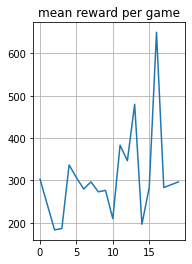

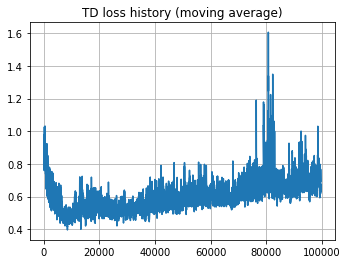

100%|██████████| 100000/100000 [1:39:37<00:00, 16.73it/s]


In [ ]:
##Train the agent
agent.epsilon=1 # set to 1 so agent explores initially
for i in trange(100000):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train the network
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        load_weigths_into_target_network(agent, target_network)
        # gradually reduce epsilon
        agent.epsilon = max(agent.epsilon * 0.999, 0.01)

    
    if i % 5000 == 0:
      #uncomment to store agent's weights every some iterations
        # agent.network.save_weights('/dqn_model_atari_weights.h5')
        #evaluate agent performance with current weights
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        
    if i % 500 == 0:
        # plot mean reward per game and TD loss history
        # clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

        


* __ TD loss __ is the MSE between agent's current Q-values and target Q-values.
* __ mean reward__ is the expected sum of r(s,a) agent gets averaged over the number of full games played.
* __ epsilon__ - agent's probability to explore under episilon greedy strategy. 